# Méthodes d'optimisation pour la segmentation d'images
### Mini-Projet de traitement d'Images 
---

In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import cv2 as cv
import skfmm 

## 1 - Présentation du problème 

## 1bis - Calcul de la fonctionnelle 

In [170]:
def functional_value(u, img, c1, c2, lam ):
    return np.sum(npl.norm(Gradient(u) + 0.001)) +  np.sum(lam*(np.abs(img - c1)**2*u) + np.sum(np.abs(img - c2)**2 *(1-u)))

## 2 - Chan-Vese level set formulation

### Construction d'um masque binaire pour l'image d'intérêt

In [171]:
img = cv.imread('eight.tif')
print("resolution = ", np.shape(img))
print("type = ", type(img))

resolution =  (242, 308, 3)
type =  <class 'numpy.ndarray'>


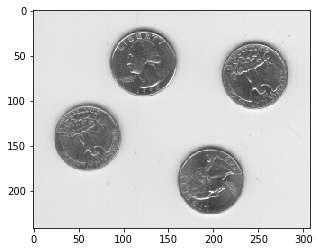

In [172]:
plt.imshow(img)

In [173]:
print(img[:,:,0])

[[225 225 225 ... 233 232 233]
 [225 225 225 ... 233 233 233]
 [226 226 225 ... 233 232 233]
 ...
 [225 226 225 ... 233 233 233]
 [226 226 225 ... 233 232 233]
 [226 226 226 ... 232 233 234]]


In [174]:
# Equivalent de roipoly ?

mask = np.zeros(img.shape[:2],dtype = 'uint8')

c = [194, 253, 293, 245]m
r = [72, 14, 76, 125]

rc = np.array((c,r)).T

cv.drawContours(mask,[rc],0,255,-1)
cv.drawContours(img,[rc],0,255,2)
mask = cv.cvtColor(mask,cv.COLOR_GRAY2BGR)
mask = mask/255.0
res = np.hstack((img,mask))

resolution =  (242, 308, 3)


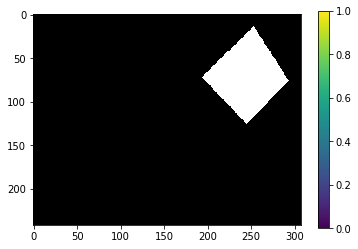

In [175]:
plt.imshow(mask)
plt.colorbar()
print("resolution = ", np.shape(mask))

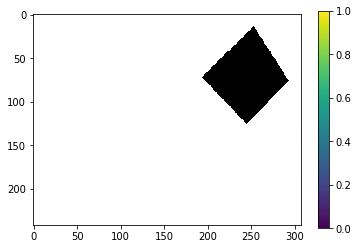

In [176]:
plt.imshow(1-mask)
plt.colorbar()

### Initialisation de la fonction phi : l'algorithme de Fast-Marching

Scikit-fmm.distance permet de calculer la distance signée entre chaque point de l'image et le bord du masque : positif à l'intérieur, négatif à l'extérieur.

In [198]:
def fast_marching(mask) : 
    Dm = skfmm.distance(mask)
    Dp = skfmm.distance(1-mask)
    return Dp-Dm

In [1]:
phi0 = fast_marching(mask)

plt.imshow(phi0[:,:,1])
plt.colorbar()

NameError: name 'fast_marching' is not defined

### Chan Vese algorithm

In [179]:
# 4 - fonction Heaviside-Eta

In [180]:
def Heaviside_eta(phi,eta):
    M = (1 + 2. * np.arctan(phi/eta) / np.pi) / 2.
    return M

In [181]:
# 5 - delta-eta, gradx, grady, div 

In [182]:
def delta_eta(phi,eta):
    M = 1. / ((1 + (phi / eta)**2) * eta * np.pi)
    return M

In [183]:
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y
def Gradient(x):
    y=[]
    y.append(GradientHor(x))
    y.append(GradientVer(x))
    return np.array(y)

In [184]:
def DivHor(x):
    N=len(x[0])
    y=x-np.roll(x,-1,axis=1)
    y[:,0]=-x[:,1]
    y[:,N-1]=x[:,N-1]
    return y
def DivVer(x):
    N=len(x)
    y=x-np.roll(x,-1,axis=0)
    y[0,:]=-x[1,:]
    y[N-1,:]=x[N-1,:]
    return y
def Div(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x

In [185]:
np.sum(img)

43990875

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


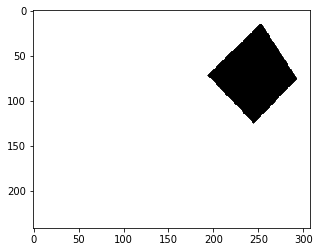

In [200]:
c1 = 50
c2 = 200
tau = 1
lbda = 1
eta = 0.5
thres = 0.001
niter = 100
phi_init = phi0
plt.imshow(phi_init)

In [201]:
def ChanVese(thres, phi, eta, img, c1, c2, tau):
    print("Iterations in progress ...")
    i = 0
    phi_1 = np.ones(np.shape(phi))
    func = []
    
    while npl.norm(phi[:,:,1] - phi_1[:,:,1], 2) > thres :
        i+=1
        Hk = Heaviside_eta(phi,eta)
        deltak = delta_eta(phi,eta)
        gradphi = Gradient(phi)

        c1 = np.sum(img*Hk)/np.sum(Hk)
        c2 = np.sum(img*(1-Hk))/np.sum(1-Hk)

        phi_1 = np.copy(phi)
        phi += tau * deltak * ( Div(gradphi/npl.norm(gradphi)) - lbda * (img - c1)**2 + lbda * (img - c2)**2) 
        if (i%10 == 0): 
            phi = fast_marching(phi)
        if (i > 500) : 
            break
        func += [functional_value(Heaviside_eta(phi, eta), img, c1, c2, lbda)] 
    print("Done.")
    return phi, i, func

In [202]:
def Fast_ChanVese(thres, phi, eta, img, c1, c2):
    print("Iterations in progress ...")
    i = 0
    phi_1 = np.ones(np.shape(phi))
    func = []
    while npl.norm(phi[:,:,1] - phi_1[:,:,1], 2) > thres and i<100:
        i+=1
        Hk = Heaviside_eta(phi,eta)
        deltak = delta_eta(phi,eta)
        gradphi = Gradient(phi)

     #   c1 = np.sum(img*Hk)/np.sum(Hk)
      #  c2 = np.sum(img*(1-Hk))/np.sum(1-Hk)

        tau_k = deltak * (Div(gradphi/npl.norm(gradphi)) - lbda * (img - c1)**2 + lbda * (img - c2)**2)
        tau_k = np.max(np.abs(tau_k))
        
        phi_1 = np.copy(phi)
        phi += tau_k * deltak * ( Div(gradphi/npl.norm(gradphi)) - lbda * (img - c1)**2 + lbda * (img - c2)**2) 
        if (i%10==0) :
            phi = fast_marching(phi)
            
        func += [functional_value(Heaviside_eta(phi, eta), img, c1, c2, lbda)] 
    print("Done.")
    return phi, i, func

In [203]:
phi_res, niter, f = Fast_ChanVese(thres, phi_init, eta, img, c1,c2)

Iterations in progress ...
Done.


Nombre d'itérations nécessaires :  100


Text(0.5, 1.0, 'Evolution de la fonctionnelle')

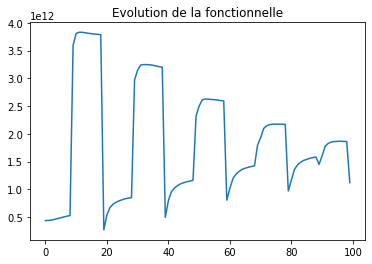

In [204]:
print("Nombre d'itérations nécessaires : ", niter)
plt.plot(f)
plt.title("Evolution de la fonctionnelle")

In [205]:
u = Heaviside_eta(phi_res, eta)

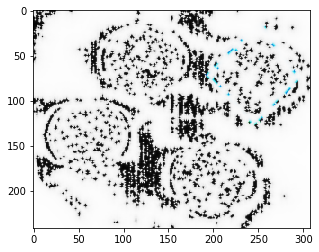

In [206]:
plt.imshow(u)

In [197]:
phi_ch, niter, f= ChanVese(thres, phi_init, eta, img, c1, c2, tau)

Iterations in progress ...


KeyboardInterrupt: 

Nombre d'itérations pour converger :  501


Text(0.5, 1.0, 'Evolution de la fonctionnelle')

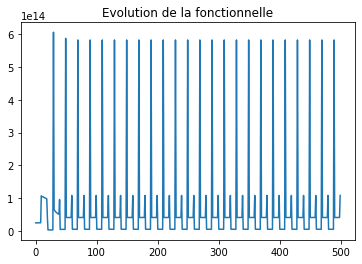

In [168]:
print("Nombre d'itérations pour converger : ", niter)
plt.plot(f)
plt.title("Evolution de la fonctionnelle")

In [135]:
u_ch = Heaviside_eta(phi_ch, eta)

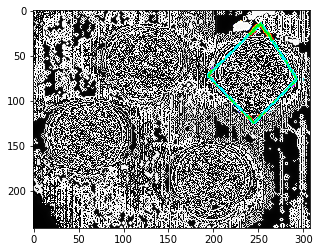

In [136]:
plt.imshow(1-u_ch)

In [137]:
kernel = np.ones((5,5),np.uint8)
u_ch = cv.dilate(u_ch, kernel, 1)
u_ch = cv.erode(u_ch, kernel, 1)

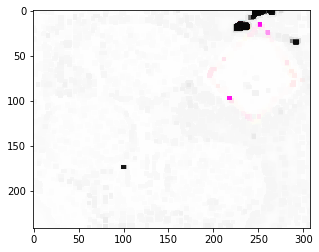

In [138]:
plt.imshow(u_ch)

## 3 - Chan, Esedoglu and Nikolova convex formulation

In [139]:
img = cv.imread('eight.tif')
print("resolution = ", np.shape(img))
print("type = ", type(img))

resolution =  (242, 308, 3)
type =  <class 'numpy.ndarray'>


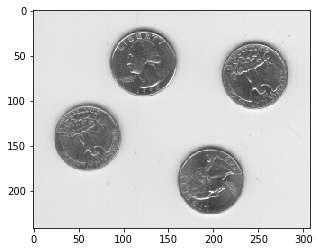

In [32]:
plt.imshow(img)

In [33]:
print(img[:,:,0])

[[225 225 225 ... 233 232 233]
 [225 225 225 ... 233 233 233]
 [226 226 225 ... 233 232 233]
 ...
 [225 226 225 ... 233 233 233]
 [226 226 225 ... 233 232 233]
 [226 226 226 ... 232 233 234]]


In [34]:
# Equivalent de roipoly ?

mask = np.zeros(img.shape[:2],dtype = 'uint8')

c = [194, 253, 293, 245]
r = [72, 14, 76, 125]

rc = np.array((c,r)).T

cv.drawContours(mask,[rc],0,255,-1)
cv.drawContours(img,[rc],0,255,2)
mask = cv.cvtColor(mask,cv.COLOR_GRAY2BGR)
mask = mask/255.0
res = np.hstack((img,mask))

resolution =  (242, 308, 3)


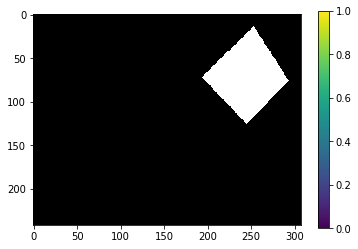

In [35]:
plt.imshow(mask)
plt.colorbar()
print("resolution = ", np.shape(mask))

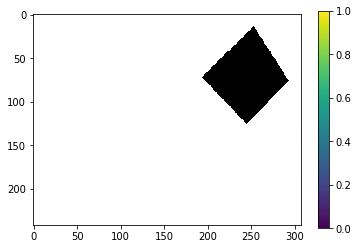

In [36]:
plt.imshow(1-mask)
plt.colorbar()

### Initialisation de la fonction phi : l'algorithme de Fast-Marching

##  

In [147]:
def Chan_Esedogu(img, fro, c1, c2, tau, thres, eps ):
    i = 1
    fro_1 = np.copy(fro)
    fro  = fro + tau*(Div(Gradient(fro)/npl.norm(Gradient(fro)+eps)) - lam *(img - c1)**2 + lam * (img - c2)**2)
    fro = np.minimum(np.maximum(fro,0),1)
    func = []
    while npl.norm(fro[:,:,1] - fro_1[:,:,1], 2) > thres :
        
        gradu = Gradient(fro)
        ite = fro + tau*(Div(gradu/npl.norm(gradu+eps)) - lam *(img - c1)**2 + lam * (img - c2)**2)
        fro_1 = np.copy(fro)
        fro = np.minimum(np.maximum(ite,0),1)
        
        Hk = Heaviside_eta(fro,eta)
        c1 = np.sum(img*Hk)/np.sum(Hk)
        c2 = np.sum(img*(1-Hk))/np.sum(1-Hk)
        print("c1 = ", c1, " c2 = ", c2)
        func += [functional_value(fro, img, c1, c2, lbda)]
        if (i > 100) :
            break
        i+=1

    return fro,i, func
        


c1 =  193.61301303243866  c2 =  203.70373992732175
c1 =  185.3280228997843  c2 =  216.79565049881114
c1 =  185.16351022482664  c2 =  217.01763257190473
c1 =  185.16338120403233  c2 =  217.0339624408353
c1 =  185.16504062225147  c2 =  217.04110615036043
c1 =  185.16565351933255  c2 =  217.0437083509022
c1 =  185.16596379587162  c2 =  217.04504525767632
c1 =  185.16625925647475  c2 =  217.0456303760921
c1 =  185.16668581642108  c2 =  217.0463335655764
c1 =  185.16705689605695  c2 =  217.04694863563734
c1 =  185.16737900555708  c2 =  217.0474864433742
c1 =  185.16765687472198  c2 =  217.04795514378276
c1 =  185.1678944166621  c2 =  217.04836154289106
c1 =  185.16809517975915  c2 =  217.04871171986463
c1 =  185.16826255426386  c2 =  217.04901126612737
c1 =  185.16827333302652  c2 =  217.04905654215034
c1 =  185.16824854062853  c2 =  217.0490465201143
c1 =  185.16822572799495  c2 =  217.04903899301226
c1 =  185.16830787532183  c2 =  217.0491661223563
c1 =  185.16843409519137  c2 =  217.0493

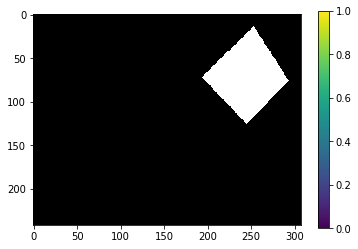

In [148]:
c1 = 110
c2 = 227
tau = 0.1
lam = 0.01
thres = 1e-5
eps = 1e-5
u0 = mask
plt.imshow(u0)
plt.colorbar()

sol, niter, functional_chan = Chan_Esedogu(img, u0, c1, c2, tau, thres, eps)

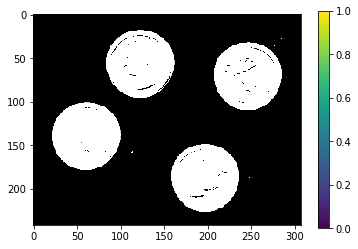

In [145]:
plt.imshow(sol)
plt.colorbar()

Nombre d'itérations :  101


Text(0.5, 1.0, 'Evolution de la fonctionnelle ')

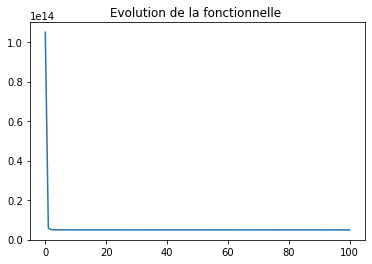

In [146]:
print("Nombre d'itérations : ", niter)
plt.plot(functional_chan)
plt.title("Evolution de la fonctionnelle ")

In [77]:
plt.imshow(ub)
plt.colorbar()

NameError: name 'ub' is not defined

## 3 - Algorithmes primaux-duaux 